In [4]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

The fast sigmoid function can be used similar to the ArcTangent function to overcome the dead neuron problem.

In [5]:
# Leaky neuron model with a custom function used in the backwards pass

class LeakySigmoidSurrogate(nn.Module):
    def __init__(self, beta, threshold = 1.0, k = 25): # k is the slope of the sigmoid function
        
        super(Leaky_Surrogate, self).__init__()

        # Initialize decay rate (beta) and threshold
        self.beta = beta
        self.threshold = threshold
        self.surrogate_func = self.FastSigmoid.apply
        
        def forward(self, input_, mem):
            spk = self.surrogate_func((mem-self.threshold)) # Call the Heaviside function
            reset = (spk - self.threshold).detach()
            mem = self.beta * mem + input_ - reset
            return spk, mem
        
        # For backward pass override Dirac Delta with gradient of fast sigmoid
        @staticmethod
        class FastSigmoid(torch.autograd.Function):
            @staticmethod
            def forward(ctx, mem, k = 25):
                ctx.save_for_backward(mem) # Store mem for use in backward pass
                ctx.k = k
                out = (mem > 0).float() # Heaviside on forward pass
                return out
            
            @staticmethod
            def backward(ctx, grad_output):
                (mem, ) = ctx.saved_tensors # Retrieve membrane potential
                grad_input = grad_output.clone()
                grad = grad_input / (ctx.k * torch.abs(mem) + 1.0) ** 2 # Gradient of fast sigmoid on backward pass
                return grad, None

The above can be implemented using snn.surrogate, where k is denoted slope.

In [8]:
spike_grad = surrogate.fast_sigmoid(slope = 25)
beta = 0.5

lif1 = snn.Leaky(beta = beta, spike_grad = spike_grad)

# Setting up the CSSN

In [10]:
# Creating dataloaders

batch_size = 128
data_path = './data/mnist'

dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0, ), (1, ))
])

mnist_train = datasets.MNIST(data_path, train = True, download = False, transform = transform)
mnist_test = datasets.MNIST(data_path, train = False, download = False, transform = transform)

train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle = True, drop_last = True)
test_loader = DataLoader(mnist_test, batch_size = batch_size, shuffle = True, drop_last = True)

In [11]:
# Neuron and simulation parameters

spike_grad = surrogate.fast_sigmoid(slope = 25)
beta = 0.5
num_steps = 50

In [12]:
# Define the network - old way

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize layers
        
        self.conv1 = nn.Conv2d(1, 12, 5) # 5x5 convolutional kernel with 12 filters
        self.lif1 = snn.Leaky(beta = beta, spike_grad = spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta = beta, spike_grad = spike_grad)
        self.fc1 = nn.Linear(64 * 4 * 4, 10)
        self.lif3 = snn.Leaky(beta = beta, spike_grad = spike_grad)
        
        def forward(self, x):
            
            # Initialize hidden states and outputs at t = 0
            mem1 = self.lif1.init_leaky()
            mem2 = self.lif2.init_leaky()
            mem3 = self.lif3.init_leaky()
            
            cur1 = F.max_pool2d(self.conv1(x), 2)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = F.max_pool2d(self.conv2(spk1), 2)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc1(spk2.view(batch_size, -1))
            spk3, mem3 = self.lif3(cur3, mem3)
            
            return spk3, mem3

In [13]:
# Define the network using nn.Sequential

# Initialize network:

net = nn.Sequential(nn.Conv2d(1, 12, 5),
                   nn.MaxPool2d(2),
                   snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True),
                   nn.Conv2d(12, 64, 5),
                   nn.MaxPool2d(2),
                   snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True),
                   nn.Flatten(),
                   nn.Linear(64 * 4 * 4, 10),
                   snn.Leaky(beta = beta, spike_grad = spike_grad, init_hidden = True, output = True)
                   ).to(device)

In [14]:
# Run a forward pass across a duration of num_steps

data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [15]:
# Wrapping the previous cell in a function, recording outputs over time

def forward_pass(net, num_steps, data):
    mem_rec = []
    spk_rec = []
    utils.reset(net) # resets the hiddden states for all LIF neurons in net
    
    for step in range(num_steps):
        spk_out, mem_out = net(data)
        mem_rec.append(mem_out)
        spk_rec.append(spk_out)
        
    return torch.stack(spk_rec), torch.stack(mem_rec)

In [16]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

# Training Loop

In this example, I'll use the total number of spikes from each neuron to calculate the Cross Entropy Loss. snnTorch includes a package of loss functions in snn.functional (analogous to torch.nn.functional), implementing a mix of cross entropy and MSE losses, which can be applied to spikes and / or membrane potential, to train a rate or latency-encoded network.

Here I'm using cross entropy loss to the output spike count to train a rate-coded network.

In [17]:
loss_fn = SF.ce_rate_loss()

Spike recordings are passed to loss_fn as the 1st argument, and the target neuron index as the second argument to generate a loss.

In [18]:
loss_val = loss_fn(spk_rec, targets)

In [20]:
print(f'The loss from an untrained network is {loss_val.item():.3f}')

The loss from an untrained network is 2.303


SF.accuracy_rate works similarly, in that it takes predicted output spikes and actual targets as arguments . Accuracy_rate assumes a rate code is used to interpret the output by checking if the index of the neuron with the highest spike count matches the target with the highest index.

In [21]:
acc = SF.accuracy_rate(spk_rec, targets)

In [23]:
print(f'The accuracy of a single batch using an untrained network is {acc*100:.3f}%')

The accuracy of a single batch using an untrained network is 14.844%


In [24]:
# Return the accuracy on the entire DataLoader object

def batch_accuracy(train_loader, net, num_steps):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()
        
        train_loader = iter(train_loader)
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec, _ = forward_pass(net, num_steps, data)
            
            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)
            
        return acc/total

In [26]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f'The total accuracy on the test set is {test_acc * 100:.3f}%')

The total accuracy on the test set is 9.796%


In [28]:
# Create training loop

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-2, betas = (0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop

for epoch in range(num_epochs):
    
    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)
        
        # Forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)
        
        # Initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)
        
        # Gradient calculation & weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        # Store the loss history for future plotting
        loss_hist.append(loss_val.item())
        
        # Test set
        if counter % 50 == 0:
            with torch.no_grad():
                net.eval()

                # Test set forward pass
                test_acc = batch_accuracy(test_loader, net, num_steps)
                print(f'Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n')
                test_acc_hist.append(test_acc.item())
        
        counter += 1

Iteration 0, Test Acc: 9.78%

Iteration 50, Test Acc: 91.90%

Iteration 100, Test Acc: 95.87%

Iteration 150, Test Acc: 96.17%

Iteration 200, Test Acc: 96.65%

Iteration 250, Test Acc: 96.70%

Iteration 300, Test Acc: 96.53%

Iteration 350, Test Acc: 97.38%

Iteration 400, Test Acc: 97.47%

Iteration 450, Test Acc: 97.80%



# Results

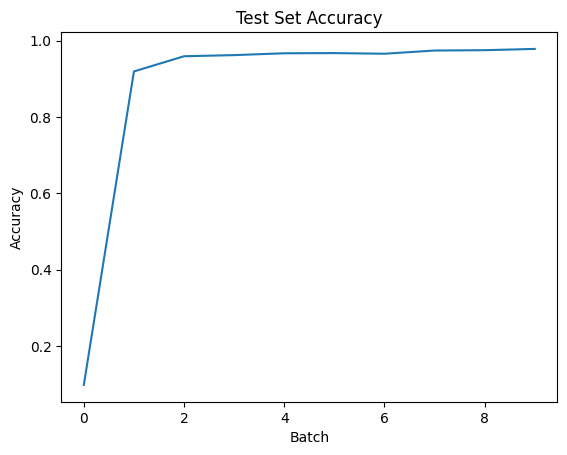

In [29]:
# Plot accuracy
fig = plt.figure(facecolor = 'w')
plt.plot(test_acc_hist)
plt.title('Test Set Accuracy')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.show()

In [30]:
# Spike counter
spk_rec, mem_rec = forward_pass(net, num_steps, data)

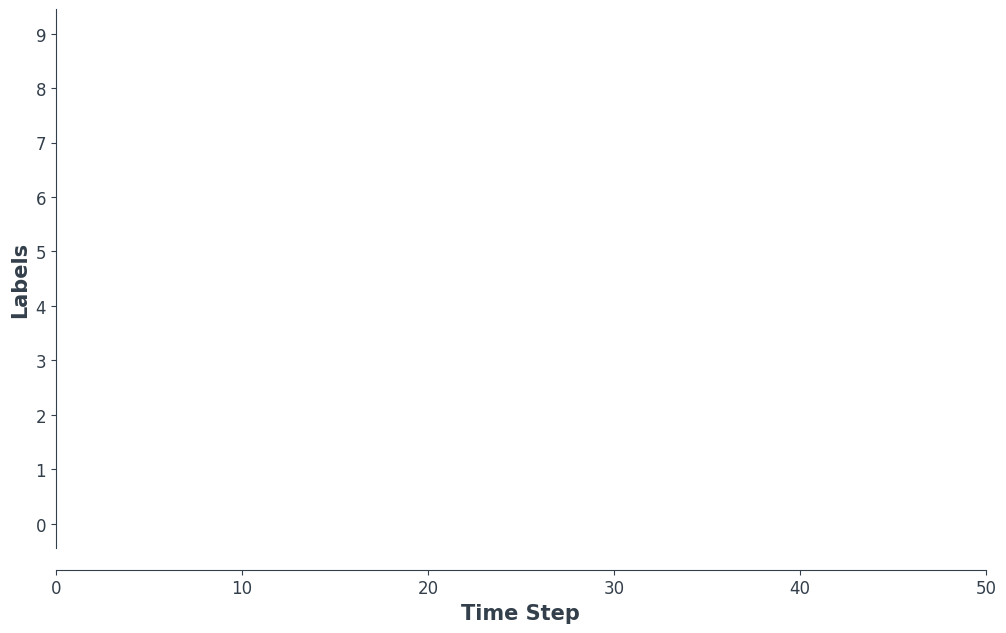

In [36]:
from IPython.display import HTML

idx = 100

fig, ax = plt.subplots(facecolor='w', figsize = (12, 7))
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8','9']

plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels = labels,
                        animate = True, interpolate = 4)

HTML(anim.to_html5_video())

In [37]:
print(f'The target label is: {targets[idx]}')

The target label is: 8
